# Load our video file into memory

Welcome to foosbot

In [1]:
#!pip install numpy
#!pip install imageio
#!pip install matplotlib

In [1]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [3,4,5], horizontal_flip_reverse_indices = [0,1,2], data_format='channels_last' )

# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\AmateurDefender\\Result\\settings.tsv"

print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [0, 2] # Predict current rod positions and future position in 2 frames
frame_rel_indexes = [0] # Use only current frame as input
training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)
training.clear_memory()


Using TensorFlow backend.


2.0.4
Opening training frames from config .\..\..\TrainingData\Processed\AmateurDefender\Result\settings.tsv.
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk0.avi
added 15932 new frames for a total of 15932
Creating training chunk from .\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
.\..\..\TrainingData\Processed\AmateurDefender\Result\chunk1.avi
added 22943 new frames for a total of 38875


# Input training frame

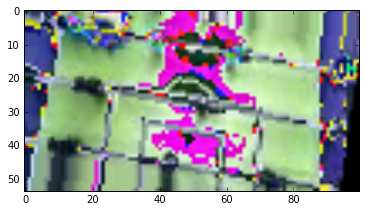

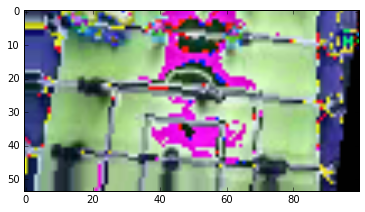

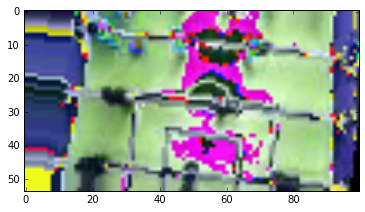

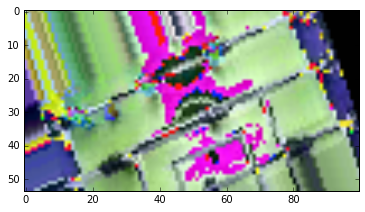

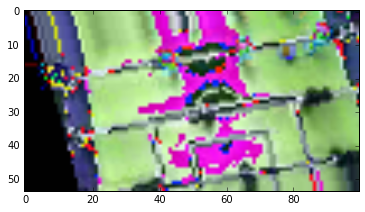

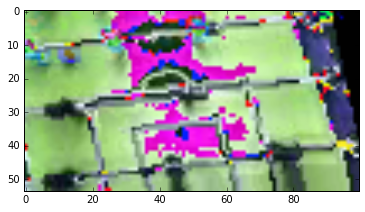

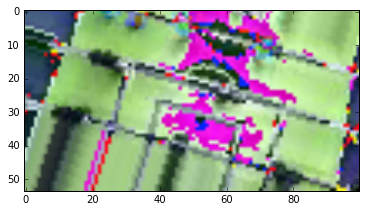

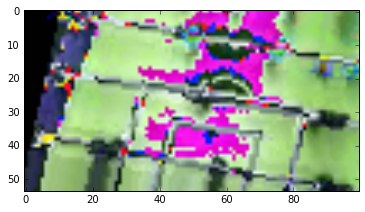

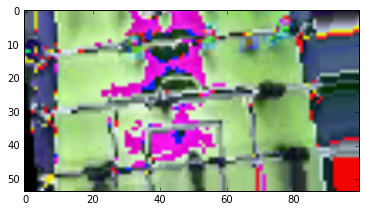

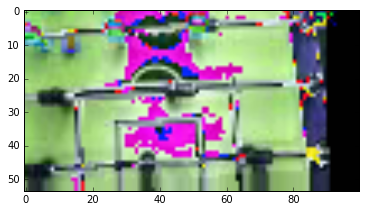

Shape of training input:
(1, 54, 100, 3)
Shape of training output:
(6,)
Corresponding Positions:


,0
0,0.427711
1,0.264493
2,0.224599
3,0.000000
4,0.000000
5,0.000000


In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

training.move_first_training_frame()

for k in range(10):
    (frame, position) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    plt.imshow(data,cmap="gray")
    plt.show()

training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)




# Train our model using CNTK

In [3]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model


def validate(model, reader, trainer):
    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    minibatch_index = 0
    minibatch_size = 1
    
    reader.reset()
    output_true = np.zeros((reader.size(),2))
    output_predicted = np.zeros((reader.size(),2))
    current_output = 0
    
    while reader.has_more():
        videos, labels, current_minibatch = reader.next_minibatch(minibatch_size)
        
        for i in range(minibatch_size):
            output_true[current_output,:] = labels[i,:]
            
            # Use the model to predict the corresponding otuput
            video = np.empty(shape=(1, 1, reader.sequence_length, reader.height, reader.width), dtype=np.float32)
            video[0,0,:,:,:] = videos[i,:,:,:]
            predictions = model.eval({model.arguments[0]:video})
            
            # Log the result
            output_predicted[current_output,:] = predictions
            
            current_output += 1
            
        
        # minibatch data to be trained with
        result = trainer.test_minibatch({input_var : videos, label_var : labels})
        #pp.pprint(result)
        metric_numer += result * current_minibatch
        #print('error rate on an unseen minibatch: {}'.format(metric_numer))
        metric_denom += current_minibatch
        # Keep track of the number of samples processed so far.
        minibatch_index += 1

    print("Validation Results: Minibatch[1-{}]: errs = {:0.2f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    plt.subplot(211)
    count = reader.size()
    true, predicted = zip(*sorted(zip(output_true[0:count,0], output_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Linear acceleration")
    plt.title("First 200 output recordings")
    plt.grid(True)
    plt.subplot(212)
    true, predicted = zip(*sorted(zip(output_true[0:count,1], output_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Angular velocity")
    plt.grid(True)
    plt.show()
    

# Training options
max_epochs = 100

# These values must match for both train and test reader.
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 3



# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))


# Build a functional model design
inputs = Input(shape=(1, image_height, image_width, image_channels,))
x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(inputs)
x = Activation('relu')(x)

x = Conv3D(124,
           kernel_size = (1, 5, 5),
           padding = "same")(x)
x = Activation('relu')(x)

# Split into two sum images
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x) # (?, 54, 100, 128, 1 )
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x) # (?, 54, 100, 128, 1 )

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x1)



x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 2, 1))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x1)
x1 = MaxPooling3D( pool_size=(1, 1, 2))(x1)

x1 = Flatten()(x1)



x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 2, 1))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = Conv3D(124,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu")(x2)
x2 = MaxPooling3D( pool_size=(1, 1, 2))(x2)

x2 = Flatten()(x2)


x = keras.layers.concatenate([x1, x2])

#x = Flatten()(x1)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)


#epoch = 45
#WEIGHTS_FNAME = 'config5_iter%i.hdf'
#model.load_weights(WEIGHTS_FNAME % epoch)
#print("Loaded model.")

#model.optimizer.lr.assign(0.00000001)

# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00001),
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

'Input shape without batches:'
(54, 100, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 54, 100, 3) 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 1, 54, 100, 12 9424        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1, 54, 100, 12 0           conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 1, 54, 100, 12 384524      activation_1[0][0]               
_______________________________________________

In [10]:

from keras.preprocessing.image import ImageDataGenerator

class TrainingIterator(object):
    def __init__(self, input):
        self.input = input
    
    def reset(self):
        self.input.move_first_training_frame()
    
    def __iter__(self):
        self.input.move_first_training_frame()
        (frames, output) = self.input.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output) = self.input.get_next_training_frame()
    
class ValidationIterator(object):
    def __init__(self, input):
        self.input = input
    
    def reset(self):
        self.input.move_first_validation_frame()
    
    def __iter__(self):
        self.input.move_first_validation_frame()
        (frames, output) = self.input.get_next_validation_frame()
        
        while frames is not None:
            yield (frames, output)
            (frames, output) = self.input.get_next_validation_frame()
            
image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = training.output_size


def TrainGen():
    while True:
        #print("TrainGen restarting training input.")
        training.move_first_training_frame()
        (frames, output) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output) = training.get_next_training_frame()
            
def ValidateGen():
    while True:
        #print("Validation restarting training input.")
        training.move_first_validation_frame()
        (frames, output) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output) = training.get_next_validation_frame()
            
def TrainBatchGen(batch_size):
    gen = TrainGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[3:6]
            #batch_outputs[i,:] = output[0:3]
            #batch_outputs[i,:] = output
            #batch_outputs[i,3:5] = 3*batch_outputs[i,3:5]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

def ValidateBatchGen(batch_size):
    gen = ValidateGen()
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, image_depth, image_height, image_width, image_channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 3), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[3:6]
            #batch_outputs[i,:] = output[0:3]
            #batch_outputs[i,:] = output
            #batch_outputs[i,3:5] = 3*batch_outputs[i,3:5]
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
    
# Train the model, iterating on the data in batches of 32 samples
#gen_train = TrainingIterator(training)
#gen_validation = ValidationIterator(training)

#(inputs, outputs) = TrainBatchGen(5000)
#print(inputs.shape)

WEIGHTS_FNAME = 'mnist_cnn_weights_%i.hdf'
MODELS_FNAME = 'mnist_cnn_models_%i.h5'
for epoch in range(10000):
    print("------ Epoch %i -------" % epoch)
    model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    #model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)


'''
(train_in, train_out) = training.get_training_frames()
(validate_in, validate_out) = training.get_validation_frames()
train_in = np.squeeze(train_in, axis=(1,))
validate_in = np.squeeze(validate_in, axis=(1,))


datagen = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)
datagen.fit(train_in)

WEIGHTS_FNAME = 'mnist_cnn_weights_%i.hdf'
for epoch in range(10000):
    print("------ Epoch %i -------" % epoch)
    #gen_train.reset()
    #gen_validation.reset()
    #model.fit_generator(TrainBatchGen(20), 1552, epochs=1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=1, validation_data=ValidateBatchGen(20), validation_steps = 500, pickle_safe=False, initial_epoch=0)
    #gen = TrainBatchGen(1000)
    #(data, labels) = next(gen)
    
    model.fit_generator(datagen.flow(train_in, train_out, batch_size=32),
                    steps_per_epoch=len(train_in) / 32, epochs=1, validation_data = (validate_in, validate_out))
    
    #model.fit(train_in, train_out, epochs=1, batch_size=32, shuffle=True, validation_data=(validate_in, validate_out))
    model.save_weights(WEIGHTS_FNAME % epoch)
'''

------ Epoch 0 -------
Epoch 1/1
1552/1552 [==============================] - 902s - loss: 0.0382 - acc: 0.3306 - val_loss: 0.0074 - val_acc: 0.2967
------ Epoch 1 -------
Epoch 1/1
1552/1552 [==============================] - 900s - loss: 0.0183 - acc: 0.3354 - val_loss: 0.0039 - val_acc: 0.2334
------ Epoch 2 -------
Epoch 1/1
1552/1552 [==============================] - 900s - loss: 0.0141 - acc: 0.3355 - val_loss: 0.0039 - val_acc: 0.2444
------ Epoch 3 -------
Epoch 1/1
1552/1552 [==============================] - 900s - loss: 0.0120 - acc: 0.3347 - val_loss: 0.0036 - val_acc: 0.2220
------ Epoch 4 -------
Epoch 1/1
1552/1552 [==============================] - 901s - loss: 0.0108 - acc: 0.3394 - val_loss: 0.0035 - val_acc: 0.2205
------ Epoch 5 -------
Epoch 1/1
1552/1552 [==============================] - 901s - loss: 0.0101 - acc: 0.3367 - val_loss: 0.0036 - val_acc: 0.3479
------ Epoch 6 -------
Epoch 1/1
1552/1552 [==============================] - 901s - loss: 0.0094 - acc: 0

KeyboardInterrupt: 

In [9]:
epoch = 41
WEIGHTS_FNAME = 'mnist_cnn_weights_%i.hdf'
#model.load_weights(WEIGHTS_FNAME % epoch)
#model.load_weights("config10.hdf")
#model.load_weights('mnist_cnn_weights_19.hdf')

#model.load_weights('model12_deltapos.hdf')
model.load_weights('config12_weights_posonly.hdf')
#del model  # deletes the existing model
#model = keras.models.load_model('config12_model.hdf')
print("Loaded model.")

#output_true = labels_validate
#output_predicted = model.predict(data_validate, batch_size=32, verbose=1)
#print("Predicted.")


Loaded model.


2000/2000 [==============================] - 28s    
Predicted.
array([[ 0.03614458,  0.00362319,  0.01604278],
       [ 0.02409638, -0.00362319,  0.05347594],
       [ 0.0060241 , -0.00724638,  0.0802139 ],
       ..., 
       [-0.01204819,  0.        ,  0.        ],
       [-0.03012048, -0.00362319,  0.        ],
       [-0.04216867, -0.00724638,  0.        ]], dtype=float32)
array([[ 0.00963295,  0.01992843,  0.01383   ],
       [ 0.01331565,  0.02433579,  0.016136  ],
       [ 0.01331565,  0.02433579,  0.016136  ],
       ..., 
       [ 0.00261912,  0.01054102,  0.00818968],
       [ 0.00178582,  0.00945274,  0.00750134],
       [ 0.0010996 ,  0.00859974,  0.00700422]], dtype=float32)


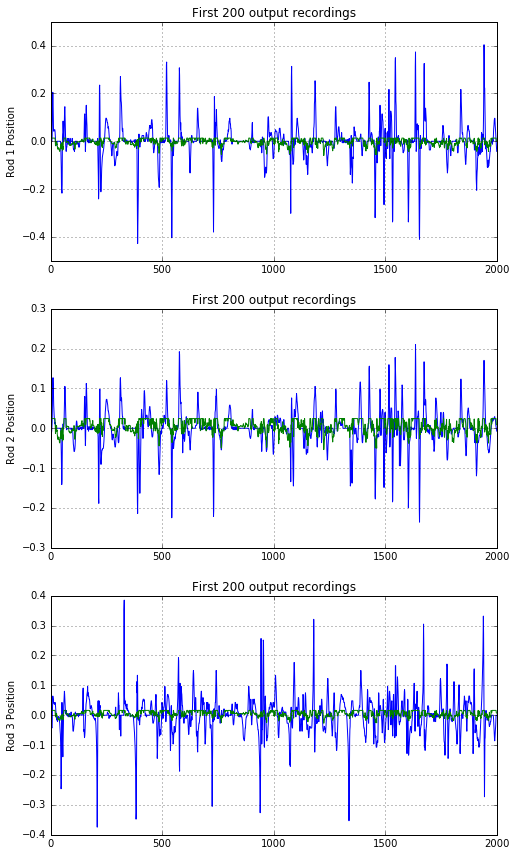

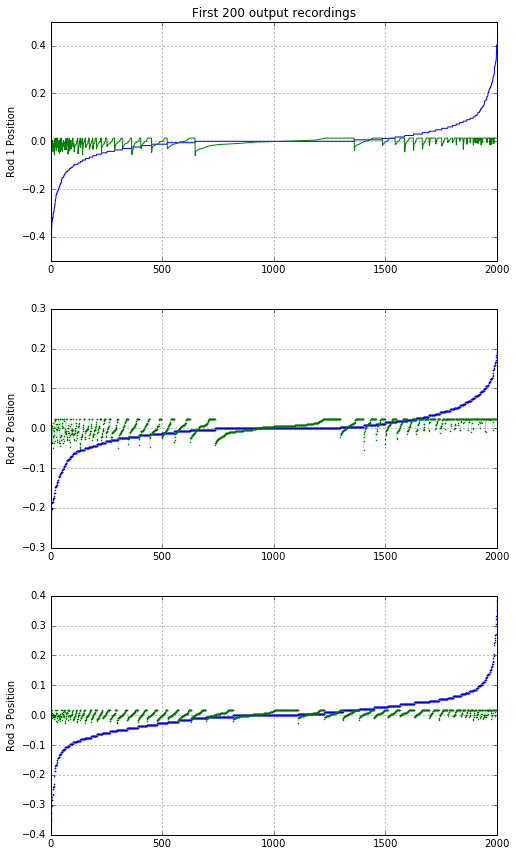

In [11]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(plot_delta):
    (frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    outputs_predicted = model.predict(frames, batch_size=32, verbose=1)
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    plt.figure(figsize=(8,30))
    count = 2000
    
    plt.subplot(611)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    plt.plot(range(count),outputs_true[0:count,1], range(count),outputs_predicted[0:count,1] )
    plt.ylabel("Rod 2 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(613)
    plt.plot(range(count),outputs_true[0:count,2], range(count),outputs_predicted[0:count,2] )
    plt.ylabel("Rod 3 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    if( plot_delta ):
        plt.subplot(614)
        plt.plot(range(count),outputs_true[0:count,3], range(count),outputs_predicted[0:count,3] )
        plt.ylabel("Delta Rod 1 Position")
        plt.title("First 200 output recordings")
        plt.grid(True)

        plt.subplot(615)
        plt.plot(range(count),outputs_true[0:count,4], range(count),outputs_predicted[0:count,4] )
        plt.ylabel("Delta Rod 2 Position")
        plt.title("First 200 output recordings")
        plt.grid(True)

        plt.subplot(616)
        plt.plot(range(count),outputs_true[0:count,5], range(count),outputs_predicted[0:count,5] )
        plt.ylabel("Delta Rod 3 Position")
        plt.title("First 200 output recordings")
        plt.grid(True)
    
    
    plt.figure(figsize=(8,30))
    plt.subplot(611)
    
    count = 2000
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1 Position")
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    plt.subplot(612)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,1], outputs_predicted[0:count,1])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 2 Position")
    plt.grid(True)
    
    plt.subplot(613)
    true, predicted = zip(*sorted(zip(outputs_true[0:count,2], outputs_predicted[0:count,2])))
    plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
    plt.ylabel("Rod 3 Position")
    plt.grid(True)
    
    if( plot_delta ):
        plt.subplot(614)
        true, predicted = zip(*sorted(zip(outputs_true[0:count,3], outputs_predicted[0:count,3])))
        plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
        plt.ylabel("Rod 1 Position in 1/2 second")
        plt.grid(True)

        plt.subplot(615)
        true, predicted = zip(*sorted(zip(outputs_true[0:count,4], outputs_predicted[0:count,4])))
        plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
        plt.ylabel("Rod 2 Position in 1/2 second")
        plt.grid(True)

        plt.subplot(616)
        true, predicted = zip(*sorted(zip(outputs_true[0:count,5], outputs_predicted[0:count,5])))
        plt.plot(range(count),true, range(count),predicted, marker='.', markersize = 2, linewidth =0.1, markerfacecolor='black')
        plt.ylabel("Rod 3 Position in 1/2 second")
        plt.grid(True)
    
    plt.show()
    
plot_validate(plot_delta=False)

In [ ]:
output_true = labels_validate_short
output_predicted = model.predict(data_validate_short, batch_size=32, verbose=1)
pp.pprint(output_true)
pp.pprint(output_predicted)